In [1]:
import cv2
from cv2 import aruco
import os
import numpy as np
import matplotlib.pyplot as plt

### New API (we don't use that)

In [2]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((6, 4), 1, 0.5, aruco_dict)

In [3]:
imboard = board.generateImage((2000, 2000))

AttributeError: 'cv2.aruco.CharucoBoard' object has no attribute 'generateImage'

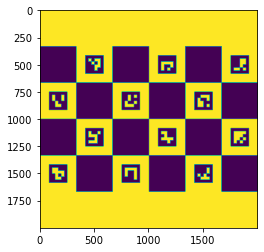

In [4]:
plt.imshow(imboard)
plt.show()

### Old API

In [4]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
# board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
board = aruco.CharucoBoard_create(6, 4, 1, 0.5, aruco_dict)
imboard = board.draw((2000, 2000))

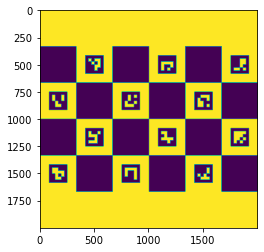

In [5]:
plt.imshow(imboard)
plt.show()

In [10]:
datadir = "./images/left/calibration/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".JPG") ])
# order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
# images = images[order]

In [11]:
images

array(['./images/left/calibration/GOPR0068.JPG',
       './images/left/calibration/GOPR0069.JPG',
       './images/left/calibration/GOPR0064.JPG',
       './images/left/calibration/GOPR0070.JPG',
       './images/left/calibration/GOPR0065.JPG',
       './images/left/calibration/GOPR0067.JPG',
       './images/left/calibration/GOPR0066.JPG'], dtype='<U38')

In [93]:
images = images[1:3]

=> Processing image ./images/left/calibration/GOPR0068.JPG
0


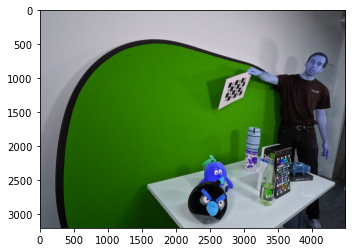

=> Processing image ./images/left/calibration/GOPR0069.JPG
0


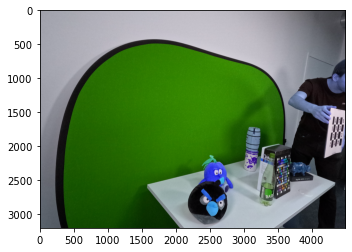

=> Processing image ./images/left/calibration/GOPR0064.JPG
0


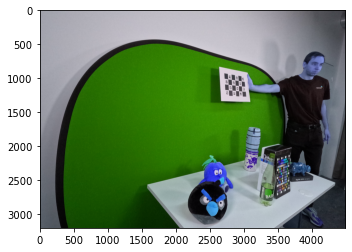

=> Processing image ./images/left/calibration/GOPR0070.JPG
12


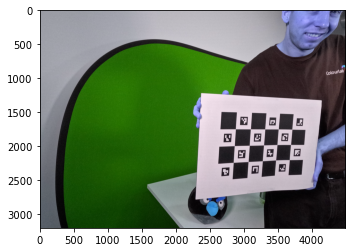

=> Processing image ./images/left/calibration/GOPR0065.JPG
0


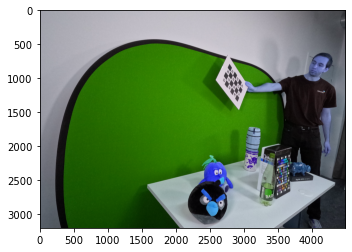

=> Processing image ./images/left/calibration/GOPR0067.JPG
0


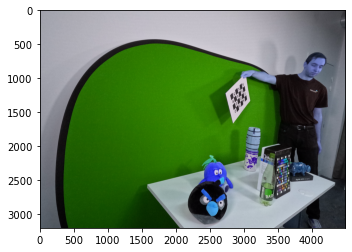

=> Processing image ./images/left/calibration/GOPR0066.JPG
0


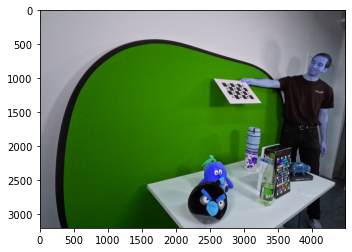

In [12]:
for i, im in enumerate(images):
    print("=> Processing image {0}".format(im))
    frame = cv2.imread(im)

    # front
#     frame = frame[1500:4000, 500:4500, :]

    # left
#     frame = frame[1500:4200, 2000:5000, :]
    
    # right
#     frame = frame[1000:3500, 1000:4000, :]

    frame = frame[1000:4200, 500:5000, :]

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print(len(corners))
    
#     img = aruco.drawDetectedMarkers(
#             image=frame, 
#             corners=corners)
    plt.imshow(frame)
    plt.show()
        

In [14]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         corners, ids, rejectedImgPoints =detector.detectMarkers(gray)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

In [221]:
allCorners, allIds, imsize=read_chessboards(images)

=> Processing image ./images/left/calibration/GOPR0068.JPG
=> Processing image ./images/left/calibration/GOPR0069.JPG
=> Processing image ./images/left/calibration/GOPR0064.JPG
=> Processing image ./images/left/calibration/GOPR0070.JPG
=> Processing image ./images/left/calibration/GOPR0065.JPG
=> Processing image ./images/left/calibration/GOPR0067.JPG
=> Processing image ./images/left/calibration/GOPR0066.JPG


In [198]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
#     flags = (cv2.CALIB_RATIONAL_MODEL)
    
#     (ret, camera_matrix, distortion_coefficients0,
#      rotation_vectors, translation_vectors,
#      stdDeviationsIntrinsics, stdDeviationsExtrinsics,
#      perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
#                       charucoCorners=allCorners,
#                       charucoIds=allIds,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix=cameraMatrixInit,
#                       distCoeffs=distCoeffsInit,
#                       flags=flags,
#                       criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    
    ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors = aruco.calibrateCameraCharuco(
        charucoCorners=allCorners,
        charucoIds=allIds,
        board=board,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=None,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [222]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

In [223]:
mtx

array([[9.91021143e+02, 0.00000000e+00, 2.37524273e+03],
       [0.00000000e+00, 9.91021143e+02, 2.56454232e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [224]:
ret

1.3422286120260092

### Camera (hero11) parameters

In [ ]:
2.7mm - fl

In [ ]:
6.40 x 5.60 - sensor size

In [ ]:
5568*4872 - pixels

In [193]:
2.7*(1/(5.6/4872))

2349.0